# 2D Laser FDTD Simulation

<a href="https://en.wikipedia.org/wiki/Laser" target="_blank">Lasers</a> are some of the most fascinating devices to have been invented. Once described as a "solution waiting for a problem", lasers have found widespread use in both industrial and commercial applications. In addition to its general usefulness, lasers have been found to exhibit a wide range of physical phenomena, such as <a href="https://aip.scitation.org/doi/abs/10.1063/1.95810?journalCode=apl" target="_blank">period doubling</a> and <a href="https://www.nature.com/articles/nphoton.2014.326" target="_blank">chaos</a>, and remain an active field of study both at the applied and at the fundamental level.

One of the most common methods to study lasers is the use of <a href="https://en.wikipedia.org/wiki/Computational_physics" target="_blank">computational methods</a>. <a href="https://en.wikipedia.org/wiki/Theoretical_physics" target="_blank">Theoretical studies</a> tend to require simplifications in order to make the problem tractable, and these simplifications sometimes make a system unrealistic, while <a href="https://en.wikipedia.org/wiki/Experimental_physics" target="_blank">experimental studies</a> tend to incur high resource costs. In a previous post we explored how to <a href="https://github.com/natsunoyuki/blog_posts/blob/main/physics/1D%20Laser%20Simulation%20in%20Python.ipynb" target="_blank">simulate a 1 dimensional laser</a> using the <a href="https://github.com/natsunoyuki/blog_posts/blob/main/physics/1D%20Electromagnetic%20FDTD%20in%20Python.ipynb" target="_blank">1 dimensional FDTD algorithm</a>. Unfortunately 1 dimensional systems tend to be simple systems with insufficient degrees of freedom. On the other hand, 3 dimensional systems require huge amounts of computational resources to solve. Hence 2 dimensional systems provide a good balance between system complexity and the amount of resources required.

In this post we will explore how to simulate a 2 dimensional laser using the <a href="https://github.com/natsunoyuki/blog_posts/blob/main/physics/2D%20Electromagnetic%20FDTD%20in%20Python.ipynb" target="_blank">2 dimensional FDTD algorithm</a>.

## The Maxwell-Bloch Equations

Lasers are described theoretically using the <a href="https://en.wikipedia.org/wiki/Maxwell–Bloch_equations" target="_blank">Maxwell-Bloch</a> equations shown below.

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/Maxwell_Bloch_eq.png?raw=True" alt="drawing" width="400"/>

These set of 4 equations describe how the electromagnetic fields __E__ and __H__ (equations 1 and 2) interact with the polarization of the cavity dielectric __P__ (equation 3) and the population inversion _D_ (equation 4). As these equations contain both temporal and spatial derivatives, numerical integrations in both time and space will be required to solve them. The finite difference time domain (FDTD) algorithm does just that.

## The 2 Dimensional FDTD Grid

We already covered the <a href="https://github.com/natsunoyuki/blog_posts/blob/main/physics/2D%20Electromagnetic%20FDTD%20in%20Python.ipynb" target="_blank">2 dimensional FDTD algorithm</a> in another post, and we will quickly quote the main concepts here. 

We use the TMz polarization case, where the electric field exists only in the _z_ direction (<i>E<sub>z</sub></i>) and the magnetic field only in the _x_ and _y_ directions (<i>H</i><sub><i>x</i></sub>, <i>H</i><sub><i>y</i></sub>). The 2 dimensional TMz polarization FDTD grid is a grid staggered in both time and space as shown in the image below. 

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/fdtd_2d_grid.jpg?raw=True" alt="drawing" width="500"/>

In each grid unit cell, we place <i>E</i><sub><i>z</i></sub> at the unit cell origin, <i>H</i><sub><i>x</i></sub> halfway along the _y_ axis and <i>H</i><sub><i>y</i></sub> halfway along the _x_ axis. In other words, if <i>E</i><sub><i>z</i></sub> has grid indices `[n, m]`, then <i>H</i><sub><i>x</i></sub> will have indices `[n, m+1/2]` and <i>H</i><sub><i>y</i></sub> indices `[n+1/2, m]`. 

Also, <i>E</i><sub><i>z</i></sub> will be evaluated at integer time steps `t`, while both <i>H</i><sub><i>x</i></sub> and <i>H</i><sub><i>y</i></sub> will be evaluated at half-integer time steps `t+1/2`. This means that the 2 dimensional FDTD grid is staggered in both space and time. This is required as both the electric and magnetic fields interact with each other, and we cannot place all 3 field components at the same spot in both time and space.

Additionally, we also place <i>P</i><sub><i>z</i></sub> and <i>D</i> at the same location in the unit cell as <i>E</i><sub><i>z</i></sub>, as both <i>P</i><sub><i>z</i></sub> and <i>D</i> explicitly depend on <i>E</i><sub><i>z</i></sub>.

Therefore using this FDTD grid setup, we update the fields in the simulation in the following order.

1. Magnetic fields <i>H</i><sub><i>x</i></sub> and <i>H</i><sub><i>y</i></sub>.

`H_x = H_x - dt / dy * (E_z[:, 1:] - E_z[:, :-1])`,

`H_y = H_y + dt / dx * (E_z[1:, :] - E_z[:-1, :])`.

2. Polarization <i>P</i>. Due to the second order derivative involved, the value of <i>P</i> must be carried over two time steps. Also, as polarization exists only within the lasing material, we use a `mask` to specify the grid points where <i>P</i> is defined.

`P = mask / c1 * (c2 * P - c3 * Pold - c4 * E_z * D)`,

`Pold = Place.copy() # Carry the value of P from 1 time step ago`,

`Place = P.copy() # Carry the value of P from 2 time steps ago`.

3. Electric field <i>E</i><sub><i>z</i></sub>.

`diff_H_x = dt / dy / E[1:-1, 1:-1] * (H_x[1:-1, 1:] - H_x[1:-1, :-1])`,
            
`diff_H_y = dt / dx / E[1:-1, 1:-1] * (H_y[1:, 1:-1] - H_y[:-1, 1:-1])`,

`diff_P = -4 * pi / E[1:-1, 1:-1] * (P[1:-1, 1:-1] - Pold[1:-1, 1:-1])`,

`E_z[1:-1, 1:-1] = E_z[1:-1, 1:-1] + diff_P + (diff_H_y - diff_H_x)`,

4. Population inversion <i>D</i>. As population inversion exists only within the lasing material, we use a `mask` to specify the grid points where <i>D</i> is defined.

`D = mask / c5 * (c6 * D + gpara * D0 + c7 * E_z * (c8 * P + c9 * Pold))`.

The full FDTD code in Python is given below.

## Absorbing Boundary Conditions

Absorbing boundary conditions are required to absorb the outwards propagating electric and magnetic fields at the simulation boundary. If absorbing boundary conditions are not implemented, the simulation boundary will act as a perfect electric conductor and fully reflect any outwards propagating waves back into the grid. In this simulation we implement the second order absorbing boundary conditions outlined in chapter 6.6 of <a href="https://eecs.wsu.edu/~schneidj/ufdtd/index.php" target="_blank">Understanding the Finite-Difference Time-Domain Method</a>, John B. Schneider, 2010.

## Coding the Laser FDTD in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import tqdm

# FDTD 2D, TMZ polarization laser simulation.
# The electric field oscillates only in the z direction, while the magnetic field
# oscillates only in the x and y directions. A staggered grid in space is used to 
# simulate E_z, H_x and H_y:
#     H_x(m, n+1/2) 
#     E_z(m, n)     H_y(m+1/2, n)

class fdtd2d_tmz_laser:
    def __init__(self, Nx = 501, Ny = 501, c = 1, dx = 1, dy = 1):
        # Grid attributes
        self.Nx = Nx # Number of x grid cells.
        self.Ny = Ny # Number of y grid cells.
        self.c = c # Speed of light, normalized to 1.
        self.dx = dx # x step size.
        self.dy = dy # y step size.
        self.dt = min(dx, dy) / np.sqrt(2) / c # Time step size.

        self.x = np.arange(Nx)
        self.y = np.arange(Ny)
        self.X, self.Y = np.meshgrid(self.x, self.y)

        # Source location
        self.source_x = int(Nx / 2)
        self.source_y = int(Ny / 2)

        # Maxwell-Bloch equation parameters
        self.gperp = 0.01
        self.gpara = self.gperp / 100.0
        self.ka = 0.1
        
        # Magnetic fields H_x and H_y
        self.H_x = np.zeros([Nx, Ny - 1])
        self.H_y = np.zeros([Nx - 1, Ny])
        
        # Electric field E_z
        self.E_z = np.zeros([Nx, Ny])
        
        # Dielectric slab attributes
        self.radius = 200
        self.mask = np.zeros([Nx, Ny])
        for i in range(Nx):
            for j in range(Ny):
                if np.sqrt((i - self.source_x)**2 + (j - self.source_y)**2) < self.radius:
                    self.mask[i, j] = 1
                    
        # Permittivity epsilon (E) and permeability mu (M)
        self.n1 = 1.0
        self.n2 = 3.0
        self.E = np.logical_not(self.mask) * self.n1**2 + self.mask * self.n2**2 
        # we assume that the dielectric is a perfect magnetic material with
        # mu = 1 everywhere. So we do not need to explicitly have a vector 
        # for mu. If this condition is not satisfied, then mu must be taken
        # into account as well in the simulation.
        
        # Polarization field P (strictly speaking P_z)
        self.P = np.zeros([Nx, Ny])
        self.Place = np.zeros([Nx, Ny]) # polarization one time step before
        self.Pold = np.zeros([Nx, Ny]) # polarization two time steps before
        
        # Population inversion D
        self.D0 = 10.0 # pump strength
        self.D = self.mask * self.D0
        
        # Time dependent field for plotting and animation
        self.E_z_t = []
        self.H_x_t = []
        self.H_y_t = []
        self.E_z_timeseries = []
        
        # Absorbing boundary coundition initialization
        self.E_z_n = self.E_z.copy()     # data for t = n
        self.E_z_n_1 = self.E_z_n.copy() # data for t = n-1
        self.H_x_n = self.H_x.copy()     # data for t = n
        self.H_x_n_1 = self.H_x_n.copy() # data for t = n-1
        self.H_y_n = self.H_x.copy()     # data for t = n
        self.H_y_n_1 = self.H_y_n.copy() # data for t = n-1
        
    def run(self, n_iter = 10000, initiate_pulse = False):
        # MB equation constants
        c1 = 1.0 / self.dt ** 2 + self.gperp / self.dt / 2.0
        c2 = 2.0 / self.dt ** 2 - self.ka ** 2 - self.gperp ** 2
        c3 = 1.0 / self.dt ** 2 - self.gperp / self.dt / 2.0
        c4 = self.ka * self.gperp / 2.0 / np.pi
        c5 = 1.0 / self.dt + self.gpara / 2.0
        c6 = 1.0 / self.dt - self.gpara / 2.0
        c7 = 2.0 * np.pi * self.gpara / self.ka
        c8 = 1.0 / self.dt + self.gperp / 2.0
        c9 = -1.0 / self.dt + self.gperp / 2.0
        
        # Absorbing boundary constants
        dtdx = np.sqrt(self.dt / self.dx * self.dt / self.dy)
        dtdx_2 = 1 / dtdx + 2 + dtdx
        c_0 = -(1 / dtdx - 2 + dtdx) / dtdx_2
        c_1 = -2 * (dtdx - 1 / dtdx) / dtdx_2
        c_2 = 4 * (dtdx + 1 / dtdx) / dtdx_2
        
        # FDTD Loop
        for n in tqdm.trange(n_iter):
            # Update magnetic fields H_x, H_y
            self.H_x = self.H_x - self.dt / self.dy * (self.E_z[:, 1:] - self.E_z[:, :-1])
            self.H_y = self.H_y + self.dt / self.dx * (self.E_z[1:, :] - self.E_z[:-1, :])

            # Update polarization field P
            self.P = self.mask / c1*(c2*self.P - c3*self.Pold - c4*self.E_z*self.D)
            self.Pold = self.Place.copy() 
            self.Place = self.P.copy() # carry the current value of P for two time steps
            
            # Update electric field E_z
            diff_H_x = self.dt / self.dy / self.E[1:-1, 1:-1] * (self.H_x[1:-1, 1:] - self.H_x[1:-1, :-1])
            diff_H_y = self.dt / self.dx / self.E[1:-1, 1:-1] * (self.H_y[1:, 1:-1] - self.H_y[:-1, 1:-1])
            diff_P = -4 * np.pi / self.E[1:-1, 1:-1] * (self.P[1:-1, 1:-1] - self.Pold[1:-1, 1:-1])
            self.E_z[1:-1, 1:-1] = self.E_z[1:-1, 1:-1] + diff_P + (diff_H_y - diff_H_x)
            
            # Update population inversion D
            self.D = self.mask / c5*(c6*self.D + self.gpara*self.D0 + c7*self.E_z*(c8*self.P + c9*self.Pold))
            
            # Pulse at time step 
            if initiate_pulse == True:
                tp = 30
                if n * self.dt <= tp:
                    C = (7 / 3) ** 3 * (7 / 4) ** 4
                    pulse = C * (n * self.dt / tp) ** 3 * (1 - n * self.dt / tp) ** 4
                else:
                    pulse = 0
                self.E_z[self.source_x, self.source_y] = self.E_z[self.source_x, self.source_y] + pulse

            # Mur ABC for top boundary
            self.E_z[0, :] = c_0 * (self.E_z[2, :] + self.E_z_n_1[0, :]) +    \
                             c_1 * (self.E_z_n[0, :] + self.E_z_n[2, :] -    \
                                    self.E_z[1, :] - self.E_z_n_1[1, :]) +    \
                             c_2 * self.E_z_n[1, :] - self.E_z_n_1[2, :]

            # Mur ABC for bottom boundary
            self.E_z[-1, :] = c_0 * (self.E_z[-3, :] + self.E_z_n_1[-1, :]) +    \
                              c_1 * (self.E_z_n[-1, :] + self.E_z_n[-3, :] -    \
                                     self.E_z[-2, :] - self.E_z_n_1[-2, :]) +    \
                              c_2 * self.E_z_n[-2, :] - self.E_z_n_1[-3, :]

            # Mur ABC for left boundary
            self.E_z[:, 0] = c_0 * (self.E_z[:, 2] + self.E_z_n_1[:, 0]) +    \
                             c_1 * (self.E_z_n[:, 0] + self.E_z_n[:, 2] -    \
                                    self.E_z[:, 1] - self.E_z_n_1[:, 1]) +    \
                             c_2 * self.E_z_n[:, 1] - self.E_z_n_1[:, 2]

            # Mur ABC for right boundary
            self.E_z[:, -1] = c_0 * (self.E_z[:, -3] + self.E_z_n_1[:, -1]) +    \
                              c_1 * (self.E_z_n[:, -1] + self.E_z_n[:, -3] -    \
                                     self.E_z[:, -2] - self.E_z_n_1[:, -2]) +    \
                              c_2 * self.E_z_n[:, -2] - self.E_z_n_1[:, -3]

            # Store magnetic and electric fields for ABC at time step n
            self.H_x_n_1 = self.H_x_n.copy() # data for t = n-1
            self.H_x_n = self.H_x.copy()     # data for t = n

            self.H_y_n_1 = self.H_y_n.copy() # data for t = n-1
            self.H_y_n = self.H_y.copy()     # data for t = n

            self.E_z_n_1 = self.E_z_n.copy() # data for t = n-1
            self.E_z_n = self.E_z.copy()     # data for t = n

            #self.E_t.append(self.E_z[self.source_x, self.source_y])
            self.E_z_t.append(self.E_z.copy())
            self.H_x_t.append(self.H_x.copy())
            self.H_y_t.append(self.H_y.copy())
            if len(self.E_z_t) > 500:
                del self.E_z_t[0]
                del self.H_x_t[0]
                del self.H_y_t[0]
                
            self.E_z_timeseries.append(self.E_z[450, 450])

    def plot_timeseries(self):
        # Plot E_z_timeseries.
        t = np.arange(0, self.dt * len(self.E_z_timeseries), self.dt)
        plt.plot(t, self.E_z_timeseries)
        plt.xlabel("Time")
        plt.ylabel("E")
        plt.grid(True)
        plt.show()
        
    def plot_E(self, i = 70):
        # Visualize the 2D electric field.
        if i >= len(self.E_z_t):
            i = len(self.E_z_t) - 1
            
        plt.figure(figsize = (5, 5))
        plt.pcolormesh(self.X, self.Y, self.E_z_t[i].T, shading = "auto", cmap = "bwr")
        
        circle = plt.Circle((self.source_x, self.source_y), self.radius, color = "k", fill = False)
        plt.gca().add_patch(circle)
        
        plt.axis("equal")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.grid(True)
        plt.show()
         
    def animate_E(self, file_dir = "fdtd_2d_E_animation.gif", N = 500):
        # animate self.E_z_t as a .gif file.
        # N: number of total steps to save as .gif animation.
        E_z_t = self.E_z_t[-N:]

        fig, ax = plt.subplots(figsize = (5, 5))
        cax = ax.pcolormesh(self.X, self.Y, E_z_t[0].T, vmin = np.min(E_z_t), vmax = np.max(E_z_t), 
                            shading = "auto", cmap = "bwr")
        plt.axis("equal")
        plt.grid(True)
        
        circle = plt.Circle((self.source_x, self.source_y), self.radius, color = "k", fill = False)
        plt.gca().add_patch(circle)

        def animate(i):
            cax.set_array(E_z_t[i].T.flatten())

        anim = FuncAnimation(fig, animate, interval = 50, frames = len(E_z_t) - 1)
        anim.save(file_dir, writer = "pillow")
        plt.show() 

In [2]:
fdtd = fdtd2d_tmz_laser()

In [3]:
fdtd.run(initiate_pulse = True)

100%|██████████| 10000/10000 [01:35<00:00, 104.80it/s]


## Visualizing the Simulation Results

The FDTD solver has a few ways of visualizing the simulation results. The first method is to plot a screenshot of the current electric fields within the laser.

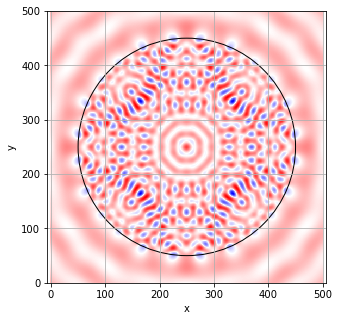

In [4]:
fdtd.plot_E()

The second visualization method is to plot an animation of the electric field. Using `matplotlib`'s `FuncAnimation` function to animate a record of _E_<sub>z</sub>(_t_), the laser can be animated for a more realistic experience of the simulation! This is already built into `fdtd2d_tmz_laser` and can be called using: `fdtd.animate_E()`. The animation is saved directly into a `.gif` file.

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/fdtd_2d_laser_animation.gif?raw=True" alt="drawing" width="400"/>

This marks the end of our exploration in simulating a 2D laser using computational methods. Although we simulated a very simple laser in this post, the same algorithm can be extended and used for more complex 2 dimensional lasers such as <a href="https://en.wikipedia.org/wiki/Random_laser" target="_blank">random lasers</a>. The same underlying algorithm is also used in more advanced FDTD solvers such as <a href="https://meep.readthedocs.io/en/latest/" target="_blank">MEEP</a>, which is widely used in both physics and engineering research.

## More Advanced Simulations
More FDTD codes can be found on my <a href="https://github.com/natsunoyuki/FDTD" target="_blank">Github repository</a> where I am working on both 1D and 2D laser simulations.

## References
* <a href="https://www.amazon.com/Laser-Light-Dynamics-II-Haken/dp/0444860215" target="_blank">Laser Light Dynamics (Volume II)</a>, H. Haken, 1986.
* <a href="https://eecs.wsu.edu/~schneidj/ufdtd/index.php" target="_blank">Understanding the Finite-Difference Time-Domain Method</a>, John B. Schneider, 2010.
* <a href="https://meep.readthedocs.io/en/latest/" target="_blank">MEEP</a> documentation.